# MAGI tutorial

This tutorial will go through step-by-step examples of how to run a MAGI job locally and some tips of how to analyze your data in a jupyter notebook. We assume that MAGI has been installed locally according to instructions on https://github.com/biorack/magi/. For specific details of what the various MAGI scores mean and how they were calculated, please see the [Help page](https://magi.nersc.gov/help/) or the [MAGI paper](https://pubs.acs.org/doi/10.1021/acschembio.8b01107).

This example input data consists of a metabolite input describing 7 features observed in a metabolomics experiment conducted on _Streptomyces coelicolor_, and a gene input file describing all the genes that were associated with the compounds that could represent those features. For an explanation of what a feature is, you can go to the [Help page](https://magi.nersc.gov/help/). For the purposes of this tutorial, you can pretend that we compared two different experimental conditions on _S. coelicolor_, and observed that those 7 features were significantly increased in one condition. Now we want to use MAGI to 
1. help refine putative compound identities to the features, 
2. help us understand the biological relevance of these features, and 
3. point us to genes that we could knock out, overexpress, or monitor the expression of in follow-up experiments.

[Step 1. Download example files](#Step-1.-Download-example-files)  
[Step 2. Create a job script and run job](#Step-2.-Create-a-job-script-and-run-job)  
[Step 3. View job details and look at results](#Step-3.-View-job-details-and-look-at-results)  
[Step 4. Analyze results](#Step-4.-Analyze-results)

# Step 0. Load python modules for this notebook
Set the path to your local MAGI directory.

In [1]:
import os
import sys
from zipfile import ZipFile
import pandas as pd
from IPython.display import Image

In [ ]:
magi_path = "path_to_local_magi_folder/magi"
sys.path.insert(0,magi_path)
from workflow import magi_job_script as mg

# Step 1. Download example files

Extract the zip file examplemagiinputfiles.zip by running the code below or by unzipping the file yourself. Place it in a folder called input_files.

In [ ]:
with ZipFile("examplemagiinputfiles.zip", 'r') as zip_ref:
    zip_ref.extractall("input_files")

## The Metabolites File

If you want to look at what a metabolites file can look like, open the **compounds_input.csv** file in Excel or with the code below. The table should look something like this. The table below shows the first 5 rows of the example metabolites file input.

|label |mz |rt_peak |rt_min |rt_max |original_compound |compound_score |
|------|------|------|------|------|------|------|
|207.0297\@4.70 |207.029678 |4.702327 |4.638008 |4.931502 |HGVAHYJMDVROLE-UHFFFAOYSA-N |0.597785 |
|207.0297\@4.70 |207.029678 |4.702327 |4.638008 |4.931502 |FBJMEOFSLTXPKH-UHFFFAOYSA-N |0.395972 |
|207.0297\@4.70 |207.029678 |4.702327 |4.638008 |4.931502 |RDPKGUWIMLIBCM-UHFFFAOYSA-N |0.353795 |
|207.0297\@4.70 |207.029678 |4.702327 |4.638008 |4.931502 |CDIRPHSIKVTLRY-UHFFFAOYSA-N |0.305327 |
|207.0297\@4.70 |207.029678 |4.702327 |4.638008 |4.931502 |HAVWRBANWNTOJX-UHFFFAOYSA-N |0.286640 |
|... |... |... |... |... |... |... |

In [ ]:
metabolites_file = pd.read_csv("input_files/compounds_input.csv")
metabolites_file.sort_values(by=["label", "compound_score"], ascending = [True, False]).head()

The only columns with "protected names" are **original_compound** and **compound_score**. The other 5 columns are descriptive and purely for your own benefit and notes. The metabolites file input can have any number of columns with any number of names, but it **must** have a column named original_compounds. See the [Help page](https://magi.nersc.gov/help/) for more details on input file formats and alternative requirements if you are performing an accurate mass search.

For these particular rows, we can see that 5 different compounds could represent a mass spectrometry feature observed at the retention time 4.70 with an _m/z value_ of 207.0297. For this dataset, the compound_score for each putative compound identification was calculated using [Pactolus](https://github.com/biorack/pactolus) to score mass fragmentation patterns of each feature against a library of _in silico_ ion fragmentation trees. These scores are user-defined and can come from anywhere, or not included at all.


## The Genes input (FASTA file)
You may also open the **example_fasta.faa** file in any text viewer; it is a standard FASTA file. This file looks something like this:

```
>640738191 SCO5328  [Streptomyces coelicolor A3(2): NC_003888]
LIIYPAALDLPHALVEWVTMLIVTREGDRRCKLRPSQRAMVALVYLREHT
TLAKIAAGFGISESTAHAYTSAVIHLLAQRAPGLLKVLLETGPDFVLLDG
TLAECDRVGDSRADYSHKHRRHGVNVQVVTDPEGRLLWLPALPGRAHDLT
AARPPHHPYLRAPGRPHPGSCLPGRRPVADHGHQTQAPAGTHPHQEDRQP
GPGRSAGIGRTRCCPPEVLADFPQSPLQPQPHDVNRQSCTHLGAATL

>640738170 SCO0206  [Streptomyces coelicolor A3(2): NC_003888]
RGRTAARLRAYMSAGGFHMNVNVLDRAVLEDAMEHPEKYPELTIRV

>637276685 SCP1.13c hypothetical protein [Streptomyces coelicolor A3(2) plasmid SCP1: NC_003903]
MPKRGSWSWIGSSQAVRRDNRDVTKHRFLVARQIGAEPFSYTRTCLDTSL
VERLRNTSLDDMTDLDAAYELTRLAMVDLEAFGTGGGETLDDQEIAVLLR
TLPAVLKRLGVALKLPFRDFKSFKSYWKDQGMSDSYAARRSYVNSVFGPA
LDQLDEYHPHLRQSRDQTRRITDVTRRRLRDGLAGAWWGGTLDEVQFLSR
LYDLDNLPSHDSRFANAARDIWQHCINNPADWEDDWIWHDERFGLADGDE
ALLRFLAEMLHPAARTDTAEVERLHAFFNETLAHDGYELIEVDSISGAPV
FAARTIGAGVPGVMKNLIFAADGPKPEFVLGDAINNDVLIVKNEQFCLVY
SQPLSASGLTWGEMISWWRARESLPADMPDNEVGRALYKRLWTSLHSDPE
RPKWLSPEQRVFRTYCELYPISETGASHPALLPQVYLHMDPKTRKERGNK
DTALGRERMDFLLLLPHGVRVVVEVDGKHHYAEGDEASPRLYAKMVAEDR
ALRLKGYEVYRFGGYELGLNSAPAMLRRFFAELLGSQP

...
```

The header of each gene sequence may contain any characters except '>'.

# Step 2. Create a job script and run job
## Set parameters for the job
Run the code below to create a job script. You may change the parameters from their default setting if you so wish. See the [Help page](https://magi.nersc.gov/help/) for more information.


In [ ]:
location_to_store_script = "." 
output_path = "./output_files"
cpu_count = 4
fasta_file = "./input_files/example_fasta.faa"
compounds_file = "./input_files/compounds_input.csv"

## Additional parameters that you can set
level = 2
final_weights = [1.0, 1.0, 1.0, 1.0]
blast_filter = 85
reciprocal_closeness = 75
chemnet_penalty = 4

In [ ]:
mg.create_job_script(location_to_store_script, output_path, cpu_count, fasta_file, compounds_file, 
    magi_path, level, final_weights, blast_filter, reciprocal_closeness, chemnet_penalty )

## Run job
Next, open a terminal on your computer. Go to the folder with the job script and run the script from there. It should take about 5 minutes on 4 computing nodes. Alternatively, you can skip this step and unzip the pre-calculated output files. If so, set the parameter below to True.

In [ ]:
use_precomputed_output_files = False

In [ ]:
with ZipFile("examplemagioutputfiles.zip", 'r') as zip_ref:
    zip_ref.extractall("output_files")

# Step 3. View job details and look at results
The log that was printed on the screen contains some information on the time that the run took and where files are stored.  

magi_results.csv is the complete set of results from the MAGI run, while magi_compound_results.csv is joined with your metabolite input file and only the best MAGI association is kept for each compound, and magi_gene_results.csv is joined with the gene headers in your FASTA input file and only the best MAGI association is kept for each gene-reaciton pair. For a detailed explanation of these files, see the [Help page](https://magi.nersc.gov/help/).

# Step 4. Analyze results
For a detailed description of the scores, see the [Help page](https://magi.nersc.gov/help/).  

[4.1. Determine the range of MAGI scores](#4.1.-Determine-the-range-of-MAGI-scores)  
[4.2. Assessing Compound Identities](#4.2.-Assessing-Compound-Identities)  
[4.3. Assessing Gene Annotations with magi_gene_results.csv](#4.3.-Assessing-Gene-Annotations-with-magi_gene_results.csv)  
[4.4. What to do with magi_results.csv](#4.4.-What-to-do-with-magi_results.csv)  


## 4.1. Determine the range of MAGI scores
Every dataset will have a different range of MAGI scores, ranging from very close to zero and up, depending on the parameters set and the compound scores you provided in the metabolites input file. As a result, knowing what the range of MAGI scores is for your dataset will come in very handy when assessing results. For this dataset, the "Max" is 5.657 and "Min" is 0.01075.


In [ ]:
if use_precomputed_output_files:
    output_path = "output_files"
magi_compound_results = pd.read_csv(os.path.join(output_path,"magi_compound_results.csv"), dtype={"gene_id":str})
magi_compound_results.head()

In [ ]:
max_score = magi_compound_results["MAGI_score"].max()
max_score

In [ ]:
magi_compound_results["MAGI_score"].min()

Optionally, you could normalize the MAGI scores within the data frame by dividing each score by the maximum value. 

In [ ]:
magi_compound_results["Normalized_MAGI_score"] = magi_compound_results["MAGI_score"]/max_score

In [ ]:
cols = magi_compound_results.columns.tolist()[:-1]
cols.insert(0,magi_compound_results.columns[-1])
magi_compound_results = magi_compound_results[cols]

In [ ]:
magi_compound_results.head()

In [ ]:
magi_compound_results.tail()

## 4.2. Assessing Compound Identities
The file magi_compound_results.csv only keeps the best result for a given compound (or compound-compound_score pair if provided). For example, if one compound was associated with two reactions and three genes, only the top-scoring metabolite-reaction-gene row would be retained.  

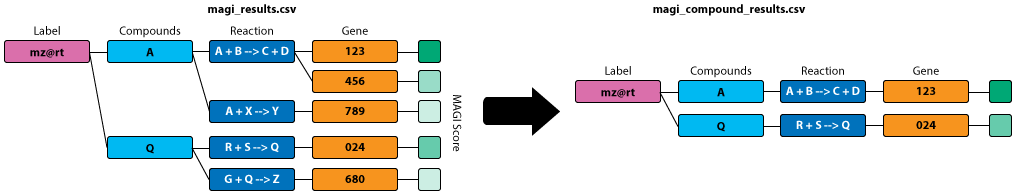

In [2]:
Image(filename = "notebook_images/magi_compound_results.png", width = 1000, height = 1000)

In this example experiment, there were seven mass spectrometry features (m/z values at a retention time peak), that could represent a total of 48 metabolites. This simulates an untargeted metabolomics experiment, where one has detected a feature of interest and wants to rank its identity among all possible metabolites. This section will show you how to interpret the relevant MAGI result files. In this case, our metabolites input file had a column named "label" that corresponded to the mass spectrometry feature that may represent a given metabolite. Several different metabolites had the same "label" description.

In [ ]:
magi_compound_results["label"].unique()

In [ ]:
magi_compound_results.shape[0] # Number of candidate metabolites

**Please note that "label" is not a required field to run MAGI. However, if you wish to assess compound identities for a feature you will need to use a description of each feature as we have here in the "label" column.**

## Open and prepare the magi_compound_results.csv file
The first order of business is to sort (and effectively group) the results by the "label" column. This will group all the results for each mass spectrometry feature together. 

In [ ]:
# Depending on the version of Pandas and Python that you have, 
# you may need the commented command instead.
magi_compound_results = magi_compound_results.sort_values(by=["label", "Normalized_MAGI_score"], ascending = [True, False])
#magi_compound_results = magi_compound_results.sort_values(by=["Normalized_MAGI_score", "label"], ascending = [False, Truea])

In [ ]:
magi_compound_results[["label", "Normalized_MAGI_score"]].head()

## Assess the MAGI results for each feature
Here we'll go over two examples of how one might go about interpreting the compound results

#### 207.0297\@4.70

In [ ]:
magi_compound_results[magi_compound_results["label"] == "207.0297@4.70"]

What you should see is that the feature labeled "207.0297\@4.70" and all of the metabolites that can be represented by the feature are in the top rows. However, only one out of these possibilities was connected to a gene (gene_id 637268765). Also, this metabolite-gene association had one of the highest MAGI scores in the dataset, which can be interpreted to mean that it is a very likely association. Given the genome input, it is highly probable that 207.0297\@4.70 is the compound HGVAHYJMDVROLE-UHFFFAOYSA-N (deoxyhdehydrochorismic acid).

#### 274.0941\@2.36

In [ ]:
magi_compound_results[magi_compound_results["label"] == "274.0941@2.36"]

The next feature, "274.0941\@2.36" appears on the surface to not be so clear-cut, as all 3 seemingly different metabolites were associated with genes. However, this feature had 7 total compounds associated with it, so this is already a 66% reduction in possible identities. But we can do better by digging into the various scores and interpreting the InChI Key code.


The lowest scoring metabolite that was associated with a gene was XQQIMTUYVDUWKJ-DJLDLDEBSA-N. The reason why this metabolite scored so much lower can be seen in the "level" column: the value here is "1", as opposed to "0." This means that XQQIMTUYVDUWKJ-DJLDLDEBSA-N or its tautomers were not connected to a gene at all; the chemical similarity network was used. In the "neighbor" column you can see that the compound WJBNIBFTNGZFBW-DJLDLDEBSA-N was the compound that was connected to gene 637267437 via the reaction [RHEA:36432](https://www.rhea-db.org/reaction?id=36432) with perfect homology (i.e. the E-value from the BLAST search was 0.0, which translates to a MAGI E-score of 200). Investigating the compound structures reveals that they are indeed similar compounds:

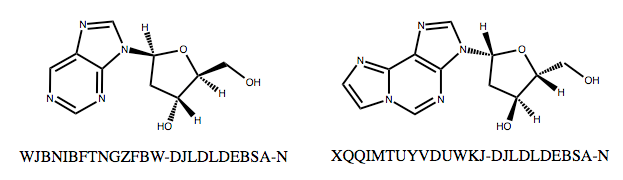

In [3]:
Image(filename = "notebook_images/neighbors_XQQIMTUYVDUWKJ_WJBNIBFTNGZFBW.png", width = 1000, height = 1000)

In [ ]:
magi_compound_results.loc[13,["Normalized_MAGI_score", "original_compound", "neighbor", "level", "gene_id", "database_id_r2g"]]

The hypothesis that MAGI makes is that WJBNIBFTNGZFBW-DJLDLDEBSA-N can substitute for XQQIMTUYVDUWKJ-DJLDLDEBSA-N in the reaction RHEA:36432. If this hypothesis is correct, then observing WJBNIBFTNGZFBW-DJLDLDEBSA-N is likely, since it can also be involved in a reaction supported by the genome. However, this hypothesis should be further assessed by looking at the reaction itself:

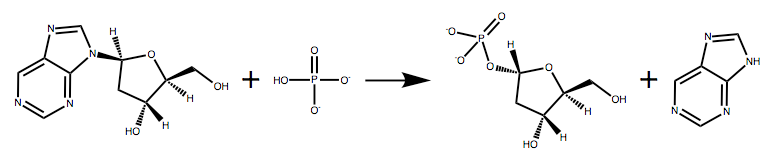

In [4]:
Image(filename = "notebook_images/rhea_36432.png", width = 1000, height = 1000)

How likely do you think it is that the extra imidazole ring on XQQIMTUYVDUWKJ-DJLDLDEBSA-N will interfere with this enzyme-catalyzed reaction? Ultimately, it would depend on docking simulations, or a biochemical experiment. This uncertainty is why searching the chemical network is penalized in the final MAGI score.

The remaining two top-scoring compounds are ZFEGYUMHFZOYIY-MKFCKLDKSA-N and ZFEGYUMHFZOYIY-YVNCZSHWSA-N. Since the "first block" of the InChI key is the same (ZFEGYUMHFZOYIY), we know that these two compounds share the same atomic connectivity, meaning the only difference between them is stereochemistry, or possible tautomerism. 

In [ ]:
magi_compound_results.loc[2:3,["Normalized_MAGI_score", "MAGI_score", "original_compound"]]

Looking at the database_id_r2g and database_id_g2r columns, we see that both stereoisomers were linked to the same reaction ([RHEA:24952](http://www.rhea-db.org/reaction?id=24952)) with perfect homology. Finally, looking at the "note" column, we see that only ZFEGYUMHFZOYIY-YVNCZSHWSA-N was linked directly to the reaction; the other stereoisomer was linked via a "flat tautomer," meaning that stereochemistry was ignored. So now we can hypothesize that based on the input genome, we are most likely seeing this specific stereoisomer of 1,6-anhydro-N-acetyl-beta-muramate.

In [ ]:
magi_compound_results.loc[2:3,["Normalized_MAGI_score", "MAGI_score", "original_compound", "database_id_r2g", "database_id_g2r", "note"]]

To summarize:

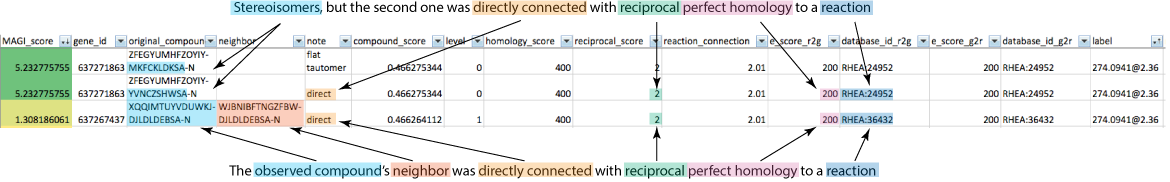

In [5]:
Image(filename = "notebook_images/colorized_compound_results.png", width = 1000, height = 1000)

## Summary
- This file is meant to determine which compound identity is most likely for a given observed mass spectrometry feature
- The MAGI score takes into account many of the considerations one would make regarding the chemical similarity network, homology, and reciprocal agreement
- However, MAGI currently cannot assess how likely it is that a similar compound (neighbor) will participate in the same reaction as an observed compound; this must be assessed manually by the researcher

## 4.3. Assessing Gene Annotations with magi_gene_results.csv
This table shows the best results for a given gene-reaction association. So for example, if MAGI associated one gene with one reaction, and that one reaction with three observed compounds, this would correspond to three rows in the full magi_results.csv table. However, in the magi_gene_results table, only the top-scoring of these three would be retained, leaving just one row to assess the gene-reaction suggestion made by magi.


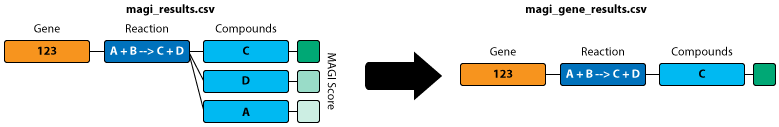

In [6]:
Image(filename = "notebook_images/magi_gene_results.png", width = 1000, height = 1000)

In [ ]:
magi_gene_results = pd.read_csv(os.path.join(output_path, "magi_gene_results.csv"), dtype={"gene_id":str})
magi_gene_results["Normalized_MAGI_score"] = magi_gene_results["MAGI_score"]/magi_gene_results["MAGI_score"].max()
cols = magi_gene_results.columns.tolist()[:-1]
cols.insert(0,magi_gene_results.columns[-1])
magi_gene_results = magi_gene_results[cols]
magi_gene_results.head()

In the example experiment, the FASTA file input had 780 genes in it. Via homology, MAGI associated these gene products with 2,277 reactions; the gene product may catalyze all or none of its proposed reactions. Since there are metabolomics data, MAGI scores these proposed functions based on the strength of the functional prediction and the strength of the metabolite observation. Here we will go through a few examples to show how you can interpret this table.

In [ ]:
magi_gene_results["gene_id"].nunique()

In [ ]:
magi_gene_results.shape[0]

**While going through this table, it is important to note that absence of evidence is not evidence of absence.** For example, if one gene is associated with 2 mutually exclusive reactions, one with weak homology and one with strong, and only the one with weak homology was associated with an observed metabolite, this does not mean that the weaker reaction is correct because perhaps another metabolomics experiment would have evidence for the stronger reaction.


## Open and prepare the magi_gene_results.csv file
The first order of business is to sort (and effectively group) the spreadsheet by the "gene_id" column. This will group all the results for each gene together.

In [ ]:
# Depending on the version of Pandas and Python that you have, 
# you may need the commented command instead.
magi_gene_results = magi_gene_results.sort_values(by=["gene_id", "Normalized_MAGI_score"], ascending = [True, False])
#magi_gene_results = magi_gene_results.sort_values(by=["Normalized_MAGI_score", "gene_id"], ascending = [False, Truea])
magi_gene_results.head()

## Assess the MAGI results for genes
If you don't have a targeted list of genes to analyze, there are a few ways you might go about prioritizing your analysis. You might want genes that had a MAGI score greater than a threshold, or a certain strength of the homology strength. The simplest way to do this in excel is probably use the dropdown menu for "MAGI_score" and/or any of the homology score columns ("homology_score", "e_score_r2g", "e_score_g2r", "reciprocal score") to filter by your desired threshold, keeping note of the genes that meet this threshold. Then, you should clear the threshold filter and filter the spreadsheet on the "gene_id" column for each or all the genes, so that you can consider all of the results for each gene.

In [ ]:
homolgy_score_filter = 100
subset_magi_gene_results = magi_gene_results[magi_gene_results["homology_score"] > homolgy_score_filter]

In [ ]:
print(magi_gene_results.shape)
print(subset_magi_gene_results.shape)

We will go through a handful of examples of how one might go about assessing these results: Genes **637266218**, **637270178** and **637269590**


#### Gene ID 637266218

In [ ]:
magi_gene_results[magi_gene_results["gene_id"] == "637266218"]

Filter your gene_results table by the gene_id column to only show the gene 637266218. This should leave only three rows to look at, all with great MAGI scores. Two rows have the same compound (GXYLOXCSJFJFKA-IOSLPCCCSA-N) linked to two different reactions, but one of them does not have reciprocal agreement, making it a weaker suggestion. Looking closer at the remaining two suggestions, we see that the two compounds [GXYLOXCSJFJFKA-IOSLPCCCSA-N](https://pubchem.ncbi.nlm.nih.gov/compound/161214) and [VNPWVMVYUSNFAW-WFMPWKQPSA-N](https://pubchem.ncbi.nlm.nih.gov/compound/440011) are actually quite similar in structure (they both have a methylthioinosine substructure), and the two reactions ([RHEA:25026](https://www.rhea-db.org/reaction?id=25026) and [RHEA:20717](https://www.rhea-db.org/reaction?id=20717) associated with them and the gene have identical mechanisms. This could be interpreted as metabolomic evidence that suggests that the gene product can catalyze both reactions.

#### Gene ID 637270178

Filter the gene_results table to only show results for gene 637270178, which should just be 2 rows. The results for this gene have medium MAGI_scores, mainly because the chemical similarity network was used to associate the gene with any observed compound. It is important to remember that these are the top-scoring MAGI results for this gene; there were no better compounds associated with this gene. 

In [ ]:
magi_gene_results[magi_gene_results["gene_id"] == "637270178"]

The reactions that this gene product could catalyze are listed in database_id_g2r: RXN-15787 and RXN-15788, catalyzing the prodigiosin and norprodigiosin synthase reactions, respectively. It is also important to remember that these results are from a gene-centric point of view: the gene sequence was used to query a reaction database. The database_id_r2g contains the reactions that were associated with both the gene and the observed compound; this can be thought of as a compound-centric view. 

What happened here is that reactions involving the observed compound or similar compounds were used to find genes that may catalyze those reactions. In this particular case, ISFCPXILUVJVOC-KYGJEJSHSA-N was associated with the undecylprodiogiosin synthase reaction, but the reaction did not have any reference sequences with which to conduct homology searches.

Instead, the chemical similarity network was used to find the similar compound WKGQSEFBQTWRPT-UHFFFAOYSA-N (prodigiosin), which is a product of the prodigiosin synthase reaction, which does have a reference sequence. This sequence had a perfect homology score of 200 (seen in the e_score_r2g column) to reaction RXN-15787. When the gene-centric and compound-centric results are merged, we see that the top-scoring row for the gene involves undecylprodigiosin (ISFCPXILUVJVOC-KYGJEJSHSA-N) associated with gene 637270178 via the prodigiosin synthase reaction (RXN-15787), with perfect homology and reciprocal agreement. 

Since ISFCPXILUVJVOC-KYGJEJSHSA-N and WKGQSEFBQTWRPT-UHFFFAOYSA-N are in fact structurally similar, it is feasible to imagine that an enzyme catalyzing the reaction RXN-15787 could also produce ISFCPXILUVJVOC-KYGJEJSHSA-N; assuming this is true, one would have strong metabolomic evidence to suggest that the gene 637270178 catalyzes a reaction similar to RXN-15787 that synthesizes undecylprodigiosin.

#### Gene ID 637269590
In our last example, we will look at gene 637269590. 

In [ ]:
magi_gene_results[magi_gene_results["gene_id"] == "637269590"]

After filtering magi_gene_results to only show results for this gene, we see four rows, each with fairly high MAGI scores, that show the gene was associated with one compound, KQWNMCHCVXVLRS-UHFFFAOYSA-N. The reason there are four rows here is because when the gene 637269590 was used as a homology search query against the reaction database, MAGI found four different reacions that the gene could have catalyzed: RXN-15413, CDPDIGLYSYN-RXN, RXN0-5515, RXN-15409 all with similar homology scores (some with identical scores). However, only one of these reactions (RXN-15413) had support from a compound observed in the metabolomics experiment (KQWNMCHCVXVLRS-UHFFFAOYSA-N). We know this because only that reaction had reciprocal agreement (reciprocal_score value equaled 2). In this case, we would have experimental evidence that suggested one gene annotation over three mutually exclusive competing annotations.


## 4.4. What to do with magi_results.csv
This table is an unfiltered table of all MAGI results. It can be used to delve deeply into compound, genes, reactions, and associations between them all.

For example, if you are interested in all of the reactions and/or genes that a compound was associated with, you may filter the table to only show rows pertaining to that compound, and then look in the "database_id_r2g" column for a list of all reactions, and "gene_id" for a list of genes associated with that compound. This could be a useful method for stitching together **biochemical pathways**.

Or, if you want to see all the compounds that a gene was connected to, you can filter the table to only show one gene, and look at the "database_id_g2r" column. This could be a useful method for curating a **metabolic model**.

Or, if you were interested to see all the **evidence** for a particular biochemical reaction, you could filter either the database_id_g2r or database_id_r2g columns to show only one reaction, and you could see all the compounds of that reaction that were observed (and similar compounds), as well as genes that were associated with that reaction. This could also be a useful method for curating a metabolic model.